Import Module

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Data Check

In [3]:
df = pd.read_csv(r'D:\Documents\Nexmedis Salsa\IMDB Dataset.csv')

print(df.head())

print(df.isnull().sum())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
review       0
sentiment    0
dtype: int64


Preprocessing and splitting data

In [4]:
def clean_text(text):
    text = re.sub(r'<br />', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

label_encoder = LabelEncoder()
df['sentiment_numeric'] = label_encoder.fit_transform(df['sentiment'])

X = df['cleaned_review']
y = df['sentiment_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modelling NLP

In [5]:
vocab_size = 10000
max_length = 200
trunc_type = 'post'
padding_type = 'post'
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),

    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

Model Training and Testing

Epoch 1/10
1250/1250 [==============================] - 1271s 1s/step - loss: 0.9336 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 2/10
1250/1250 [==============================] - 1184s 947ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4961
Epoch 3/10
1250/1250 [==============================] - 1156s 925ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 4/10
1250/1250 [==============================] - 1120s 896ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 5/10
1250/1250 [==============================] - 1081s 865ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 6/10
1250/1250 [==============================] - 1062s 849ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 6: early stopping


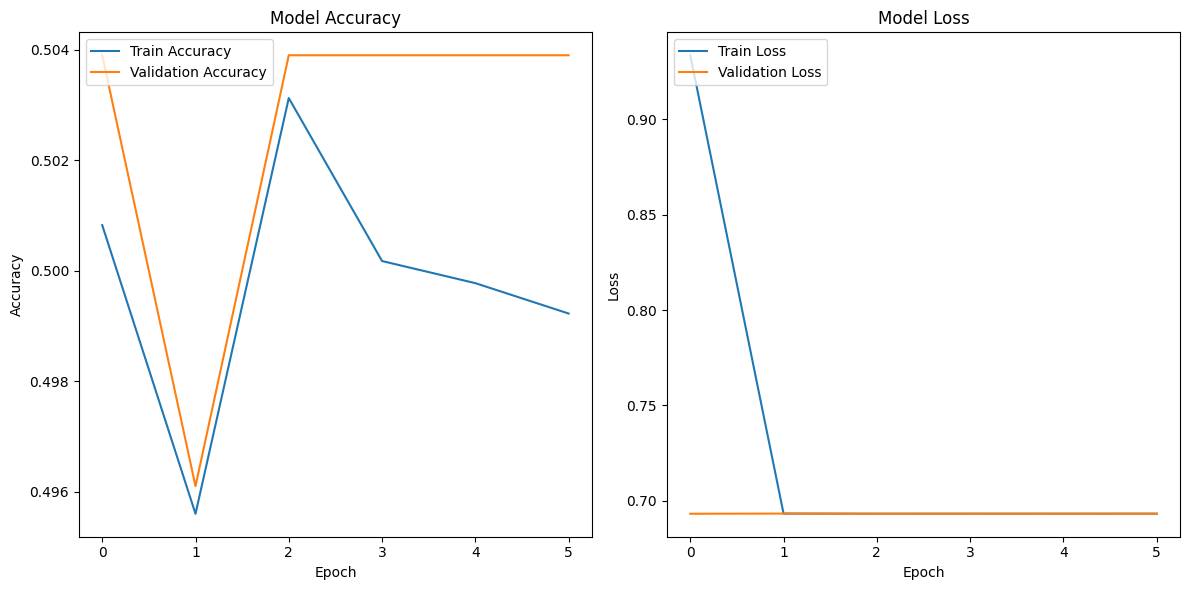

Test Accuracy: 50.39%
Test Loss: 0.6931


In [6]:
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

history = model.fit(
    X_train_padded, 
    y_train,
    epochs=10,
    validation_data=(X_test_padded, y_test),
    batch_size=32,
    callbacks=[early_stop]
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")